In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import plotly.express as px
import os
import numpy.linalg as la

import sklearn.linear_model

import matplotlib.pyplot as plt
%matplotlib inline

# Trip distribution

The purpose of this notebook is to learn how to work with simple gravity models for trip distribution.

First, let's load the population, commuting, and municipality data from the first exercise:

In [2]:
df_employment = pd.read_parquet("employment.parquet")
df_commutes = pd.read_parquet("commutes.parquet")

# geopandas
df_municipalities = gpd.read_parquet("municipalities.parquet")

**Task**: As before, reduce all data sets to the area of Île-de-France.

In [3]:
idf_departments = ["75", "92", "93", "94", "95", "77", "91", "78"]

In [4]:
# Insert code here ...
# ...

df_employment = df_employment[df_employment["municipality_id"].str[:2].isin(idf_departments)]
df_municipalities = df_municipalities[df_municipalities["municipality_id"].str[:2].isin(idf_departments)]

df_commutes = df_commutes[
    df_commutes["origin_id"].str[:2].isin(idf_departments) &
    df_commutes["destination_id"].str[:2].isin(idf_departments)
]

**Task**: Keeping track of the order of the data will be important. Set up a fixed list of municipalities and adjust the indices of all data sets. Especially, take care of the commuting data set.

Hint: Make use of `pd.MultiIndex.from_product`

In [5]:
# Insert code here ...
# ...

# municipalities = 

# df_emloyment = 
# df_commutes = 

municipalities = df_municipalities["municipality_id"].unique()

df_employment = df_employment.set_index("municipality_id").reindex(municipalities)

df_commutes = df_commutes.set_index(["origin_id", "destination_id"]).reindex(
    pd.MultiIndex.from_product([municipalities, municipalities], names = ["origin_id", "destination_id"]))

Have a look at your data sets after reindexing, do you notice anything special?

**Task**: How many flow values can we theoretically have (between all zones) in Île-de-France? For how many do we have actual values?

In [6]:
# Insert code here ...
# ...

len(df_commutes), np.count_nonzero(~df_commutes.isna()), np.count_nonzero(~df_commutes.isna()) / len(df_commutes)

(1656369, 123787, 0.07473395119082765)

**Task**: Replace missing values by zero (zero commuters).

In [7]:
# Insert code here ...
# ...

df_commutes["weight"] = df_commutes["weight"].fillna(0.0)

## Friction term

The first step in setting up our model is to obtain the friction term.

**Task**: The gravity model puts into relation different places in the study area. The friction term describes how easy it is to reach one municipality from another one. The first step is, therefore, to obtain the distances between all zones. Complete the following code to set up a distance matrix `distance_matrix`.

In [8]:
centroids = df_municipalities["geometry"].centroid
centroids = np.array([centroids.x, centroids.y] ).T

distance_matrix = np.zeros((len(municipalities), len(municipalities)))

for k in range(len(municipalities)):
    # distance_matrix[k,:] = # Calculate the Euclidean distance, you may also try numpy.linalg.norm
    
    distance_matrix[k,:] = la.norm(centroids[k] - centroids, axis = 1)

**Task:** Plot the distance matrix (it may take a while)

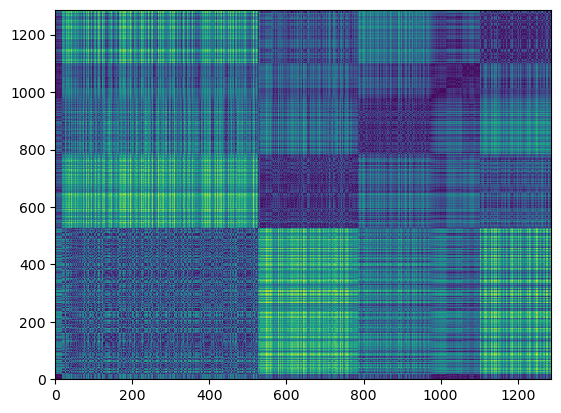

In [9]:
plt.pcolor(distance_matrix)

**Task**: Analogously to the distance matrix, we need a flow matrix indicating all observed movements (`weight`) between all zones. Obtain this matrix by transforming the commuting data set into a matrix.

Hint: Have a look at `numpy.ndarray.reshape`

In [10]:
# Insert code here ...
# ...

# flow_matrix = 

flow_matrix = df_commutes["weight"].values.reshape((len(municipalities), len(municipalities)))

**Task**: Now we obtain the data to set up the friction model:
- Bin the distances into about twenty distance bins and sum up the commuters you find in each distance bin
- Plot how much flow occurs at every distance bin

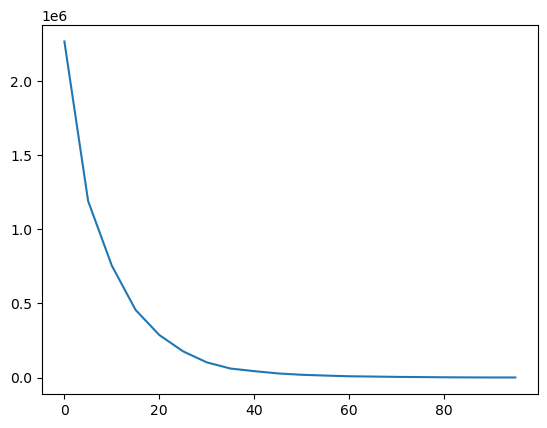

In [11]:
df_friction = pd.DataFrame({
    "distance": distance_matrix.flatten(),
    "flow": flow_matrix.flatten()
})

distance_classes = np.arange(20) * 5000

# Hint: Check numpy.digitize

# Insert code here ...
# ...

df_friction["distance_class"] = np.digitize(df_friction["distance"], distance_classes)
df_friction = df_friction.groupby("distance_class")["flow"].sum().reset_index()

plt.plot(distance_classes * 1e-3, df_friction["flow"].values)

**Task**: Now divide the obtained flow in each bin by the total flow, to obtain an empirical probability density function (pdf). Plot the function in absolute coordinates and with the probability logarithmized. What do you observe?

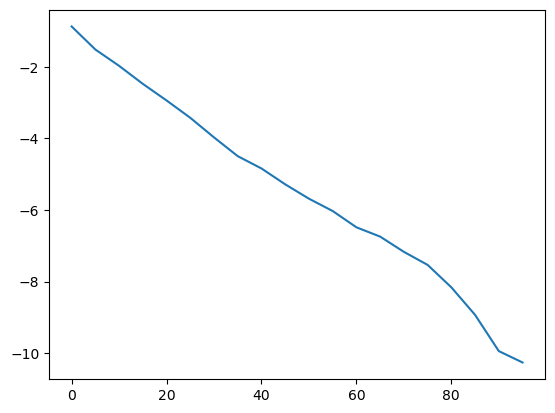

In [12]:
# Insert code here ...
# ...

# pdf = 

pdf = df_friction["flow"].values / df_friction["flow"].sum()
plt.plot(distance_classes * 1e-3, np.log(pdf))

**Task**: In logarithmic space, manually (or automatically, if you like), fit a linear function on the graph that you see.

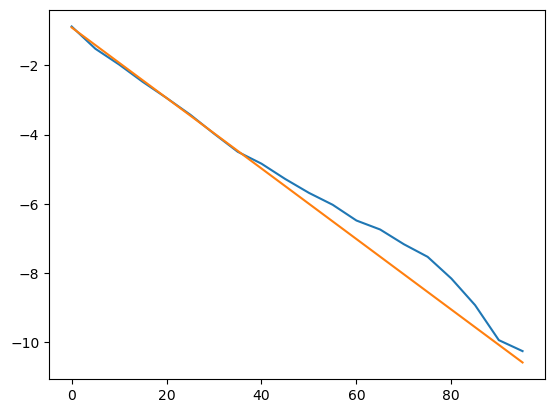

In [13]:
# Insert code here ...
# ...

# a = ?
# b = ?

# logy = a + b * np.log(pdf)

a = -0.9
b = -1.02e-4

logy = a + b * distance_classes

plt.plot(distance_classes * 1e-3, np.log(pdf))
plt.plot(distance_classes * 1e-3, logy)

**Task**: Now plot the initial data along with your fitted curve in linear space. How does you friction model look like?

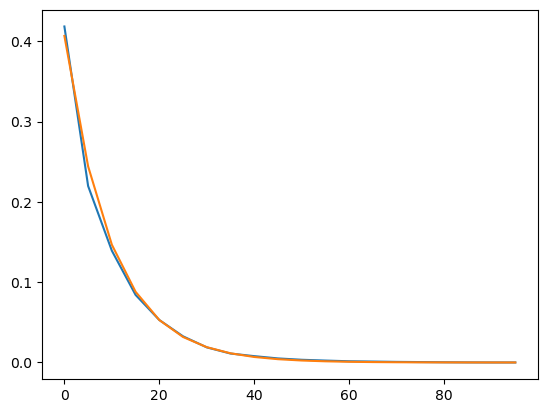

In [14]:
# Insert code here ...
# ...

a = -0.9
b = -1.02e-4

logy = a + b * distance_classes

plt.plot(distance_classes * 1e-3, pdf)
plt.plot(distance_classes * 1e-3, np.exp(logy))

**Task**: Based on your distance matrix and your friction model, calculate a friction matrix:

In [15]:
# Insert code here ...
# ...

# friction_matrix = 

friction_matrix = np.exp(a + b * distance_matrix)

## Double-constrained gravity model

Let's move on to the double-constrained model. In that model, both the origin and destination flows $O_i$ and $D_j$ are known and we aim to automatically find the attraction and production terms $A_j$ and $P_i$.

The model is defined as follows:

$$
F_{ij} = \frac{O_i \cdot D_i}{(\sum_i P_i \cdot \rho_{ij})\cdot (\sum_j A_j \cdot \rho_{ij})}
$$

the attraction and production terms are obtained by iteratively executing:

$$
P_i = \frac{O_i}{\sum_j A_j \cdot \rho_{ij}}
$$
$$
A_j = \frac{D_j}{\sum_i P_i \cdot \rho_{ij}}
$$

**Task**: Implement the double-constrained gravity model to calculate the production and attraction terms.

In [18]:
### Insert code here
# ...

# origins = # Format properly
# destinations = # Format properly

# production = # Initialize to one
# attraction = # Initialize to one

# for iteration in range(500):
#    for i in range(len(municipalities)):
        # ...

#    for j in range(len(municipalities)):
        # ...

origins = np.sum(flow_matrix, axis = 1)
destinations = np.sum(flow_matrix, axis = 0)

production = np.ones((len(municipalities),))
attraction = np.ones((len(municipalities),))

for iteration in range(500):
    for i in range(len(municipalities)):
        production[i] = origins[i] / np.sum(attraction * friction_matrix[i,:])
    
    for j in range(len(municipalities)):
        attraction[j] = destinations[j] / np.sum(production * friction_matrix[:,j])

production

array([118.93844426, 188.15612963, 282.37499326, ..., 344.19734321,
         7.23253365,  38.39127473])

**Task**: Calculate the resulting flows of your model. Compare the flows with the reference data, and also compare origin and destination flows in two additional plots.

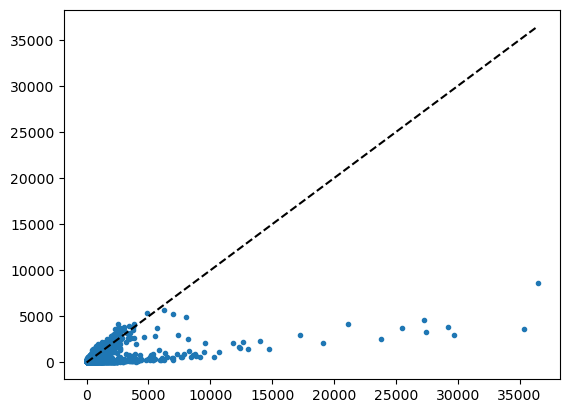

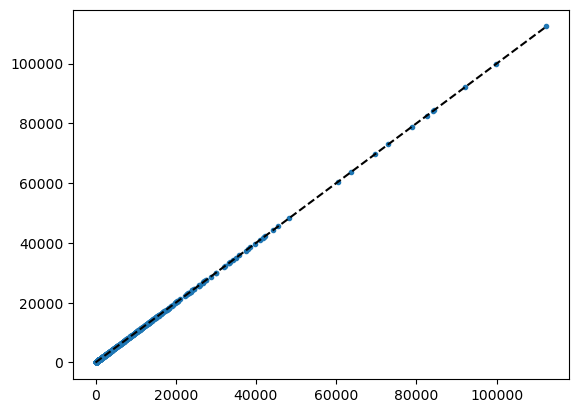

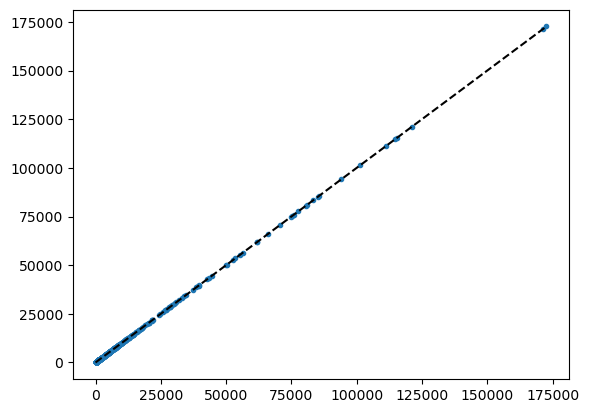

In [20]:
### Insert code here
# ...

F = np.copy(friction_matrix)

for i in range(len(municipalities)):
    F[i,:] *= origins[i] / np.sum(attraction * friction_matrix[i,:])

for j in range(len(municipalities)):
    F[:,j] *= destinations[j] / np.sum(production * friction_matrix[:,j])

plt.figure()
plt.plot(flow_matrix.flatten(), F.flatten(), ".")
plt.plot([0, np.max(flow_matrix)], [0, np.max(flow_matrix)], "k--")

plt.figure()
plt.plot(np.sum(flow_matrix, axis = 1), np.sum(F, axis = 1), ".")
plt.plot([0, np.max(np.sum(flow_matrix, axis = 1))], [0, np.max(np.sum(flow_matrix, axis = 1))], "k--")

plt.figure()
plt.plot(np.sum(flow_matrix, axis = 0), np.sum(F, axis = 0), ".")
plt.plot([0, np.max(np.sum(flow_matrix, axis = 0))], [0, np.max(np.sum(flow_matrix, axis = 0))], "k--")

What do you observe? Which municipalities could be the outliers on the bottom of the flow comparison?

**Task**: Provide the same plot and color the flows in red which go from one municipality to itself.

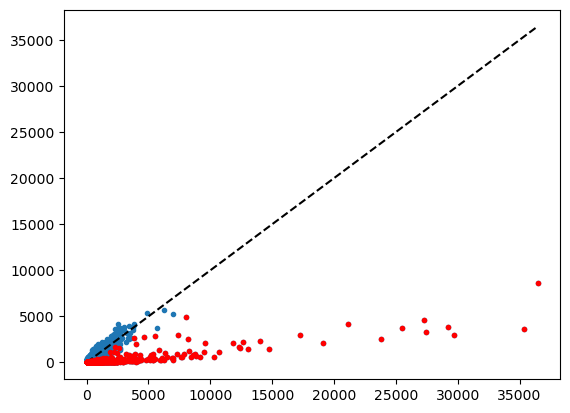

In [25]:
plt.figure()
plt.plot(flow_matrix.flatten(), F.flatten(), ".")
plt.plot([0, np.max(flow_matrix)], [0, np.max(flow_matrix)], "k--")

indices = np.arange(len(municipalities)) * len(municipalities) + np.arange(len(municipalities))
plt.plot(flow_matrix.flatten()[indices], F.flatten()[indices], "r.")

**Task**: Try to estimate a new model using the following modified friction term:

$$
F'_{ij} = \begin{cases}
    F_{ij} & \text{if} i \neq j \\
    F_{ij} + \gamma & \text{if} i = j
\end{cases}
$$

Which parameter $\gamma$ works best?

Hint: Keep your existing friction matrix in `friction_matrix` and create new matrices on the fly for testing.

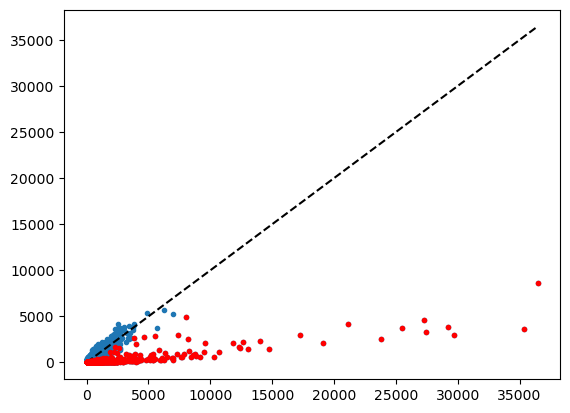

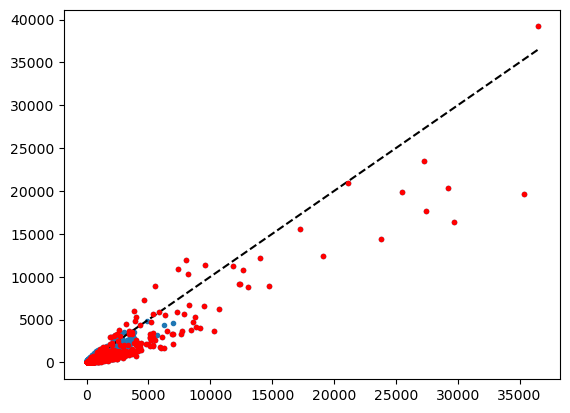

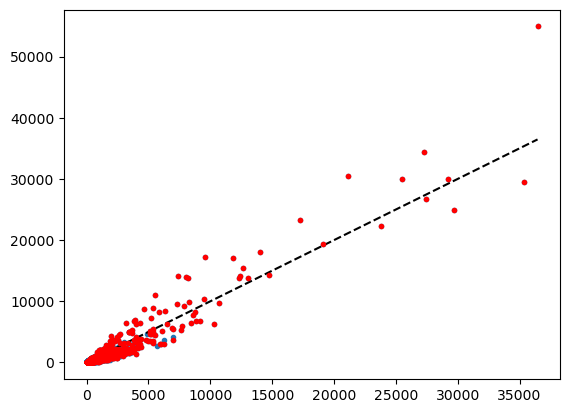

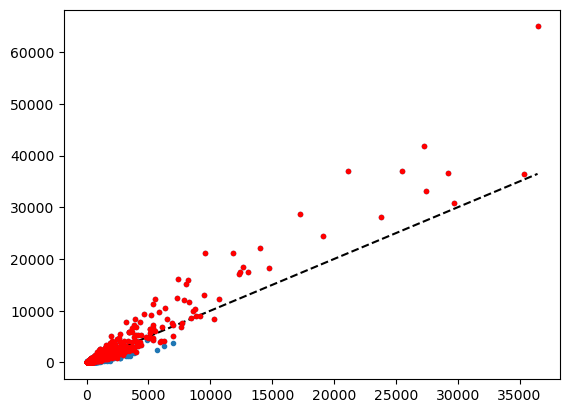

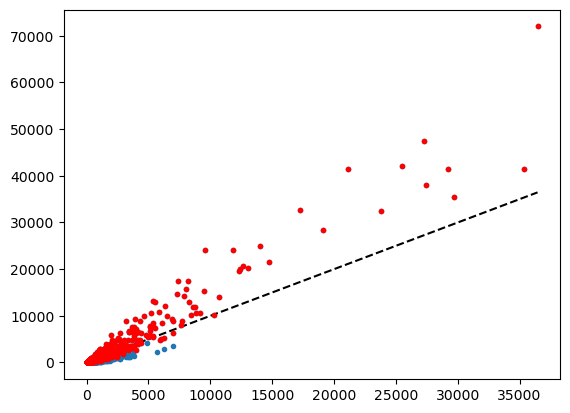

In [27]:
# Insert code here ...
# ...

gammas = np.linspace(0, 10, 5)

for gamma in gammas:
    updated_friction_matrix = friction_matrix + np.eye(len(municipalities)) * gamma

    origins = np.sum(flow_matrix, axis = 1)
    destinations = np.sum(flow_matrix, axis = 0)
    
    production = np.ones((len(municipalities),))
    attraction = np.ones((len(municipalities),))
    
    for iteration in range(500):
        for i in range(len(municipalities)):
            production[i] = origins[i] / np.sum(attraction * updated_friction_matrix[i,:])
        
        for j in range(len(municipalities)):
            attraction[j] = destinations[j] / np.sum(production * updated_friction_matrix[:,j])

    F = np.copy(updated_friction_matrix)

    for i in range(len(municipalities)):
        F[i,:] *= origins[i] / np.sum(attraction * updated_friction_matrix[i,:])
    
    for j in range(len(municipalities)):
        F[:,j] *= destinations[j] / np.sum(production * updated_friction_matrix[:,j])
    
    plt.figure()
    plt.plot(flow_matrix.flatten(), F.flatten(), ".")
    plt.plot([0, np.max(flow_matrix)], [0, np.max(flow_matrix)], "k--")
    
    indices = np.arange(len(municipalities)) * len(municipalities) + np.arange(len(municipalities))
    plt.plot(flow_matrix.flatten()[indices], F.flatten()[indices], "r.")

**Task**: Do you remeber the initial data frame `df_commutes`? Add a new column to this data frame into which you write your latest modeling results. Show the data frame.

In [21]:
### Insert code here
# ...

df_flow = df_commutes.copy()
df_flow["model"] = F.reshape((-1,))
df_flow

weight       model
origin_id destination_id                         
75101     75101           3179.161525  203.482675
          75102            363.425022  187.535179
          75103             68.745733   82.527483
          75104            113.951744  107.144565
          75105             83.242573  130.344529
...                               ...         ...
95690     95676              0.000000    0.141535
          95678              0.000000    0.010559
          95680              0.000000    0.111268
          95682              0.000000    0.000756
          95690             14.846050    0.110137

[1656369 rows x 2 columns]

Save the data set for the next exercise.

In [29]:
df_flow.to_parquet("flow.parquet")

**Congratulations!** You can now solve exercise 2.3 of the course project.